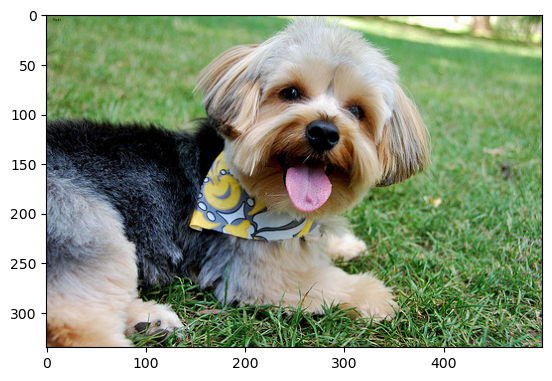

mps


In [178]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import imageio
img_path="./images/yorkshire_terrier_96.jpg"
import numpy as np
# train test split
from sklearn.model_selection import train_test_split
import time

# Load the image and display it
plt.imshow(plt.imread(img_path))
plt.show()


if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)



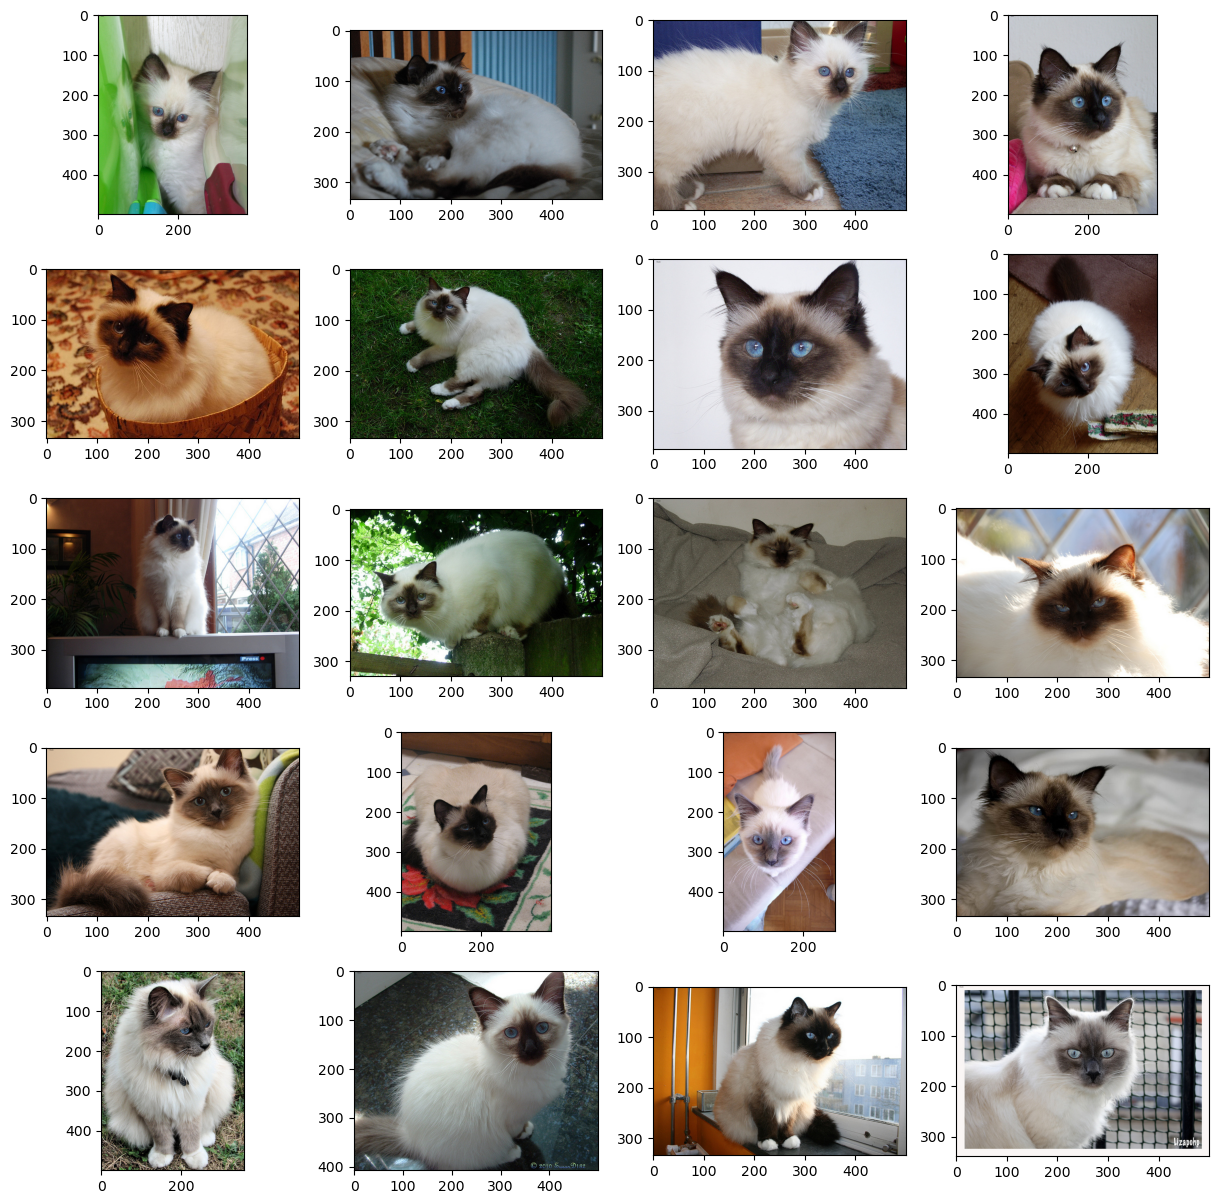

In [16]:
w=10
h=10
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = imageio.v3.imread("./images/Birman_{}.jpg".format(i))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [156]:
# get all image paths from "./images" folder
import os
from glob import glob
paths = glob("./images/*.jpg")

# the labels are the first part of the image name
labels = [os.path.basename(path).split("_")[0] for path in paths]

# create dictionary of labels and their index
label_to_idx = {label: i for i, label in enumerate(set(labels))}
idx_to_label = {i: label for i, label in enumerate(set(labels))}
label_idx = [label_to_idx[label] for label in labels]

# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(paths, label_idx, test_size=0.2, random_state=42)


miniature
torch.Size([3, 224, 224])


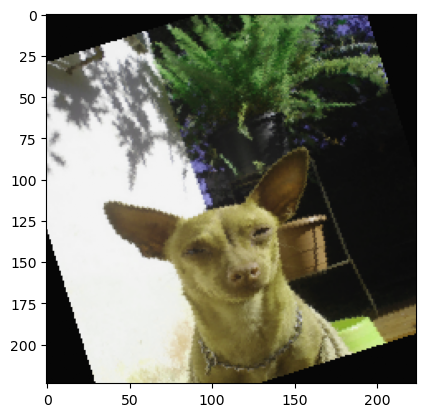

In [157]:
# create torch dataset with image path and label
class PetDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = imageio.v2.imread(self.paths[idx])
        # if image is grayscale, convert it to rgb
        try:
            if img.shape[2] == 4:
                img = img[:, :, :3]
        except:
            #image is grayscale and has only 2 dimensions
            # insert a dimension for the channel and repeat the image 3 times
            img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]


myTransforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

ds= PetDataset(x_train, y_train, myTransforms)
img, label = ds[0]
plt.imshow(img.permute(1, 2, 0))
print(idx_to_label[label.item()])
print(img.shape)

In [158]:
class MyConvModel(nn.Module):
    def __init__(self):
        super(MyConvModel, self).__init__()
        self.conv1=nn.Conv2d(3, 32, 3)
        self.conv2=nn.Conv2d(32, 64, 3, stride=2)
        self.conv3=nn.Conv2d(64, 128, 3, stride=2)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.lin1=nn.Linear(128*6*6, 1000)
        self.lin1_bn = nn.BatchNorm1d(1000)
        self.lin2=nn.Linear(1000, 37)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x=self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x=self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x=self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        #print("after conv", x.shape)
        x=x.view(-1, 128*6*6)
        #print("after flatten", x.shape)
        x=self.dropout(x)
        x=F.relu(self.lin1_bn(self.lin1(x)))
        #print(x.shape)
        x=self.dropout(x)
        x=self.lin2(x)
        return x




In [175]:
def validate():
    correct = 0
    total = 0
    for xb, yb in iter(test_loader):
        xb=xb.to(device)
        yb=yb.to(device)
        pred = model(x)
        _, predicted = torch.max(pred, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    return 100 * correct / total

In [169]:
batch_size=32

train_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(PetDataset(x_test, y_test, myTransforms), batch_size=batch_size, shuffle=True)
model = MyConvModel()

xb, yb = next(iter(train_loader))
model(xb)

tensor([[-0.1350, -0.6394, -0.9753,  ..., -0.3868,  0.2270,  0.2492],
        [ 0.8095, -0.0819, -0.4350,  ..., -0.2724, -0.0275, -0.2119],
        [ 0.3211,  0.3888,  0.2881,  ..., -0.4635,  0.1481,  0.2097],
        ...,
        [ 0.1600, -0.1270,  0.4097,  ..., -0.3656,  0.8218,  0.0892],
        [-0.1248, -0.4367, -0.0658,  ..., -0.2020, -0.3767,  0.5844],
        [-0.6409, -0.9025, -0.7473,  ..., -1.0433,  0.2135, -0.4192]],
       grad_fn=<AddmmBackward0>)

In [177]:
from tqdm.notebook import tqdm

model=MyConvModel()
import torchvision.models as models
loss_func=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.6)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model.to(device)
epochs=20
c=0
running_loss=0
current_time=time.time()
batch_count=len(train_loader)

for epoch in tqdm(range(epochs)):
    for x, y in iter(train_loader):
        x=x.to(device)
        y=y.to(device)
        y_hat=model(x)
        loss=loss_func(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        # print statistics
        if c % 20 == 19:    # print every 20 mini-batches
            print('Epoch %d | %d/%d | loss: %.3f | %.3f sec' %
                  (epoch + 1, c + 1, batch_count, running_loss/20, time.time()-current_time))
            running_loss=0
            current_time=time.time()
        c=c+1
    print("End of Epoch %d | accuracy: %.3f" % (epoch + 1, validate()))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 | 20/185 | loss: 3.586 | 4.896 sec
Epoch 1 | 40/185 | loss: 3.446 | 4.383 sec
Epoch 1 | 60/185 | loss: 3.362 | 4.765 sec
Epoch 1 | 80/185 | loss: 3.314 | 4.906 sec
Epoch 1 | 100/185 | loss: 3.247 | 4.711 sec
Epoch 1 | 120/185 | loss: 3.185 | 4.687 sec
Epoch 1 | 140/185 | loss: 3.162 | 4.387 sec
Epoch 1 | 160/185 | loss: 3.190 | 4.539 sec
Epoch 1 | 180/185 | loss: 3.030 | 4.447 sec
End of Epoch 1 | accuracy: 37.500
Epoch 2 | 200/185 | loss: 2.986 | 13.446 sec
Epoch 2 | 220/185 | loss: 2.950 | 4.485 sec
Epoch 2 | 240/185 | loss: 2.990 | 4.798 sec
Epoch 2 | 260/185 | loss: 2.985 | 4.795 sec
Epoch 2 | 280/185 | loss: 2.927 | 4.704 sec
Epoch 2 | 300/185 | loss: 2.911 | 4.800 sec
Epoch 2 | 320/185 | loss: 2.973 | 4.800 sec
Epoch 2 | 340/185 | loss: 2.806 | 4.641 sec
Epoch 2 | 360/185 | loss: 2.931 | 4.392 sec
End of Epoch 2 | accuracy: 26.241
Epoch 3 | 380/185 | loss: 2.782 | 13.863 sec
Epoch 3 | 400/185 | loss: 2.799 | 4.527 sec
Epoch 3 | 420/185 | loss: 2.816 | 4.669 sec
Epoch 3 | 

KeyboardInterrupt: 

20.6781914893617